In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import random

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
with open('../input/smart-reply-sentence-similarity/input_texts.pickle', 'rb') as handle:
    input_texts = pickle.load(handle)
    
with open('../input/smart-reply-clustering-input/input_dbscan.pickle', 'rb') as handle:
    dbscan = pickle.load(handle)

In [4]:
print(len(input_texts))
print(len(dbscan.labels_))

5001
5001


In [5]:
dbscan.labels_.shape

(5001,)

In [6]:
input_texts[:10]

['yes it helped him smooth out his dance moves',
 'hi. do you like to dance',
 "yeah good point. he also invented some women's names",
 'do you know how google maps calculates traffic',
 'i am not sure how do they do this',
 'do you like comic books',
 'hi do you like fish',
 'you as well..',
 "doesn't music needs melody .)",
 'lots of rap does have that.']

In [7]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1

In [8]:
input_tokens = tokenizer.texts_to_sequences(input_texts)
input_tokens[:10]

[[15, 12, 961, 152, 962, 178, 120, 153, 1422],
 [14, 2, 1, 8, 13, 153],
 [25, 16, 321, 34, 99, 279, 137, 963, 445],
 [2, 1, 17, 11, 179, 1423, 1424, 964],
 [3, 105, 40, 74, 11, 2, 31, 2, 106],
 [2, 1, 8, 604, 280],
 [14, 2, 1, 8, 226],
 [1, 58, 37],
 [446, 57, 965, 1425],
 [605, 19, 201, 154, 7, 9]]

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences[:,:-1]
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [10]:
labels = np.array(dbscan.labels_, copy=True)
labels[labels == -1] = len(set(dbscan.labels_)) - 1
print(labels[:10])

[36 36 36 36 36  0  0 36 36 36]


In [11]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(5001, 37)

In [12]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 256, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 256)            811520    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 37)                9509      
Total params: 1,346,341
Trainable params: 1,346,341
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
125/125 [==============================] - 7s 33ms/step - loss: 1.6327 - accuracy: 0.6978 - val_loss: 0.7790 - val_accuracy: 0.8292
Epoch 2/10
125/125 [==============================] - 2s 18ms/step - loss: 0.6214 - accuracy: 0.8487 - val_loss: 0.6653 - val_accuracy: 0.8272
Epoch 3/10
125/125 [==============================] - 2s 18ms/step - loss: 0.5027 - accuracy: 0.8693 - val_loss: 0.5686 - val_accuracy: 0.8382
Epoch 4/10
125/125 [==============================] - 2s 17ms/step - loss: 0.4163 - accuracy: 0.8870 - val_loss: 0.5483 - val_accuracy: 0.8412
Epoch 5/10
125/125 [==============================] - 2s 17ms/step - loss: 0.3422 - accuracy: 0.8904 - val_loss: 0.5250 - val_accuracy: 0.8482
Epoch 6/10
125/125 [==============================] - 2s 17ms/step - loss: 0.2936 - accuracy: 0.9058 - val_loss: 0.4926 - val_accuracy: 0.8511
Epoch 7/10
125/125 [==============================] - 2s 20ms/step - loss: 0.2722 - accuracy: 0.9061 - val_loss: 0.4560 - val_accuracy: 0.8551

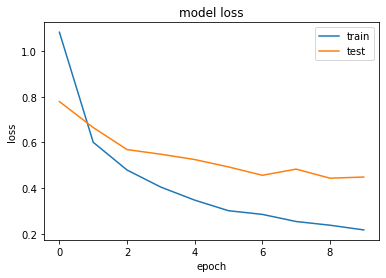

In [14]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
with open('../input/smart-reply-sentence-similarity/target_texts.pickle', 'rb') as handle:
    target_texts = pickle.load(handle)

In [16]:
def get_response(seed_text):
    print(seed_text)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_index = model.predict_classes(token_list, verbose=0)
    if predicted_index[0] == len(set(dbscan.labels_)) - 1:
        print("Predicting outside clusters")
        predicted_index = -1
    # randomly pick 1 index
    possible_response = np.where(dbscan.labels_==predicted_index)[0]
    #print(type(possible_response))
    response_index = random.sample(possible_response.tolist(), 1)[0]
    # print(response_index)
    return target_texts[response_index].replace("\t", "").replace("\n", "")

In [17]:
get_response("good morning")

good morning


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'hello. looks like a great day.'

In [18]:
get_response(input_texts[234])

have a good weekend too.
Predicting outside clusters


'i did the kavanaugh stuff. did you'

In [19]:
get_response(input_texts[34])

that is insane. do you watch the academy awards
Predicting outside clusters


'no james corden is also in it.'

In [20]:
get_response("how are you")

how are you


'i watch time to time'